# King County Housing Data Project

## Overview

A company that buys houses to flip and resell is interested in finding out what pre-existine features of houses are likely to lead to a higher sale price. Since they plan on "flipping" the house, or adding their own renovations, they aren't as interested in details such as the overall condition of the house and are more interested in things such as location, how big of a lot the house is built on, etc.

## Business Understanding

The features of the data from a housing dataset that I will be looking at, and comparing to the sale price of the houses, include number of bedrooms, number of bathrooms, square footage of the living area, square footage of the lot, number of floors, whether the house is on a waterfront, whether the house is adjacent to a green belt, whether the house has traffic noise or other nuisances, and the quality of the view of the house. 
After performing exploratory data analysis and determining which of these factors seem to relate to sale price, I will narrow down my efforts to determine which of those factors are the best predictors of sale price.

<!--[Real Estate Photo 2](Images/houseflip2.jpeg)-->
<img src="Images/houseflip2.jpeg" alt="House Flip" Style="height: 300px; width: 600px;">

## Data Understanding

I begin by importing the necessary modules and the dataset I will be using, which includes housing data for King County.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import numpy as np
import math
import matplotlib.cm as cm
%matplotlib nbagg
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('Data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


Next, I try to find out more about the data and narrow down the dataframe I will be using to only include the necessary columns.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [4]:
data_ = pd.to_datetime(data['date'])

In [5]:
data_.describe(datetime_is_numeric=True)

count                            30155
mean     2021-11-21 01:02:13.351019776
min                2021-06-10 00:00:00
25%                2021-08-18 00:00:00
50%                2021-11-03 00:00:00
75%                2022-03-07 00:00:00
max                2022-06-09 00:00:00
Name: date, dtype: object

## Data Preparation

#### Before I look at the predictors, I want to investigate the target variable ('price'):

I start by plotting the target variable's distribution with a histogram and its residuals with a QQ plot. 

<IPython.core.display.Javascript object>


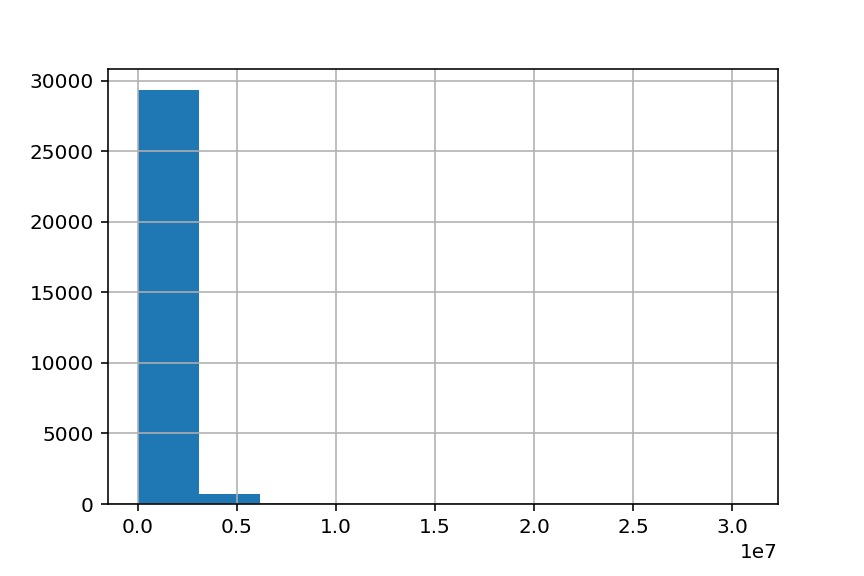

In [6]:
data['price'].hist();

<IPython.core.display.Javascript object>


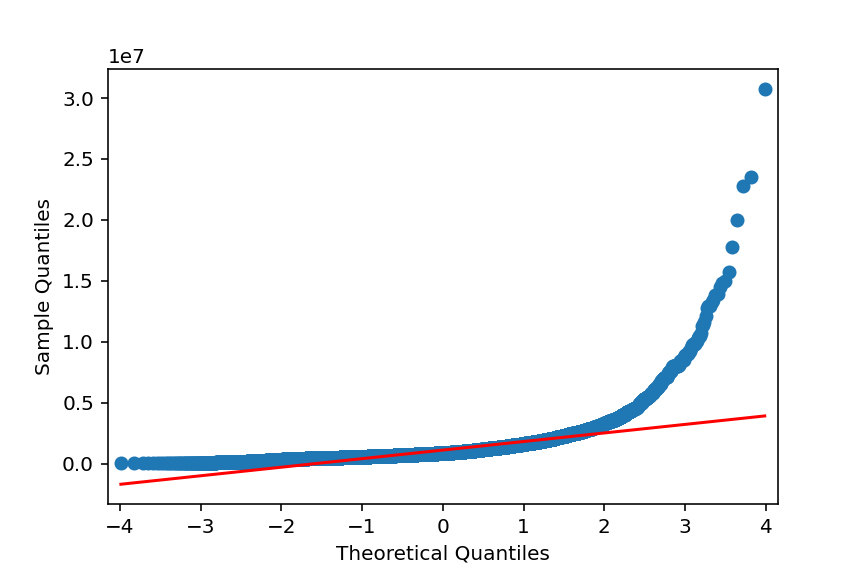

In [7]:
price_qq = sm.qqplot(data['price'], line='r');

The histogram does not seem to show a perfectly normal looking distribution, and the QQ plot shows the residuals getting further and further away from the theoretical fit line. 

In [8]:
lower_lim = np.mean(data['price']) - (2*np.std(data['price']))
upper_lim = np.mean(data['price']) + (2*np.std(data['price']))

In [9]:
lower_lim

-684205.7543299033

In [10]:
upper_lim

2901277.4300719034

This indicates that the data becomes unreliable outside of plus or minus 2 standard deviations from the mean, or outside of the range where price equals between 684,205.75 and 2,901,227.43 dollars.


#### Choosing a baseline model feature:

Next, I want to know which variables are most correlated with price, so that I can choose a feature for the baseline model. However, first I want to make sure that if any features are causing multicollinearity, that they are removed so that they will not later affect my results.

In [11]:
data_all = data.copy()

In [12]:
data_pred = data_all.iloc[:,2:21]
data_pred.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built
0,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969
1,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950
2,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956
3,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010
4,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012


In [13]:
data_pred.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built
price,1.000000,0.289204,0.480401,0.608521,0.085730,0.180576,0.538651,0.245058,0.264169,0.313409,0.096013
bedrooms,0.289204,1.000000,0.589273,0.637874,0.003306,0.147592,0.547164,0.238502,0.319441,0.183439,0.146191
bathrooms,0.480401,0.589273,1.000000,0.772677,0.035886,0.404412,0.674924,0.260902,0.457022,0.327551,0.443648
sqft_living,0.608521,0.637874,0.772677,1.000000,0.119563,0.304240,0.883984,0.338460,0.511740,0.396030,0.291694
sqft_lot,0.085730,0.003306,0.035886,0.119563,1.000000,-0.032097,0.129231,0.004111,0.087169,0.155250,0.001750
floors,0.180576,0.147592,0.404412,0.304240,-0.032097,1.000000,0.448281,-0.248093,0.132656,0.125183,0.544646
sqft_above,0.538651,0.547164,0.674924,0.883984,0.129231,0.448281,1.000000,-0.066801,0.560551,0.312117,0.387448
sqft_basement,0.245058,0.238502,0.260902,0.338460,0.004111,-0.248093,-0.066801,1.000000,0.026361,0.210500,-0.230226
sqft_garage,0.264169,0.319441,0.457022,0.511740,0.087169,0.132656,0.560551,0.026361,1.000000,0.216354,0.447560
sqft_patio,0.313409,0.183439,0.327551,0.396030,0.155250,0.125183,0.312117,0.210500,0.216354,1.000000,0.138409


<IPython.core.display.Javascript object>


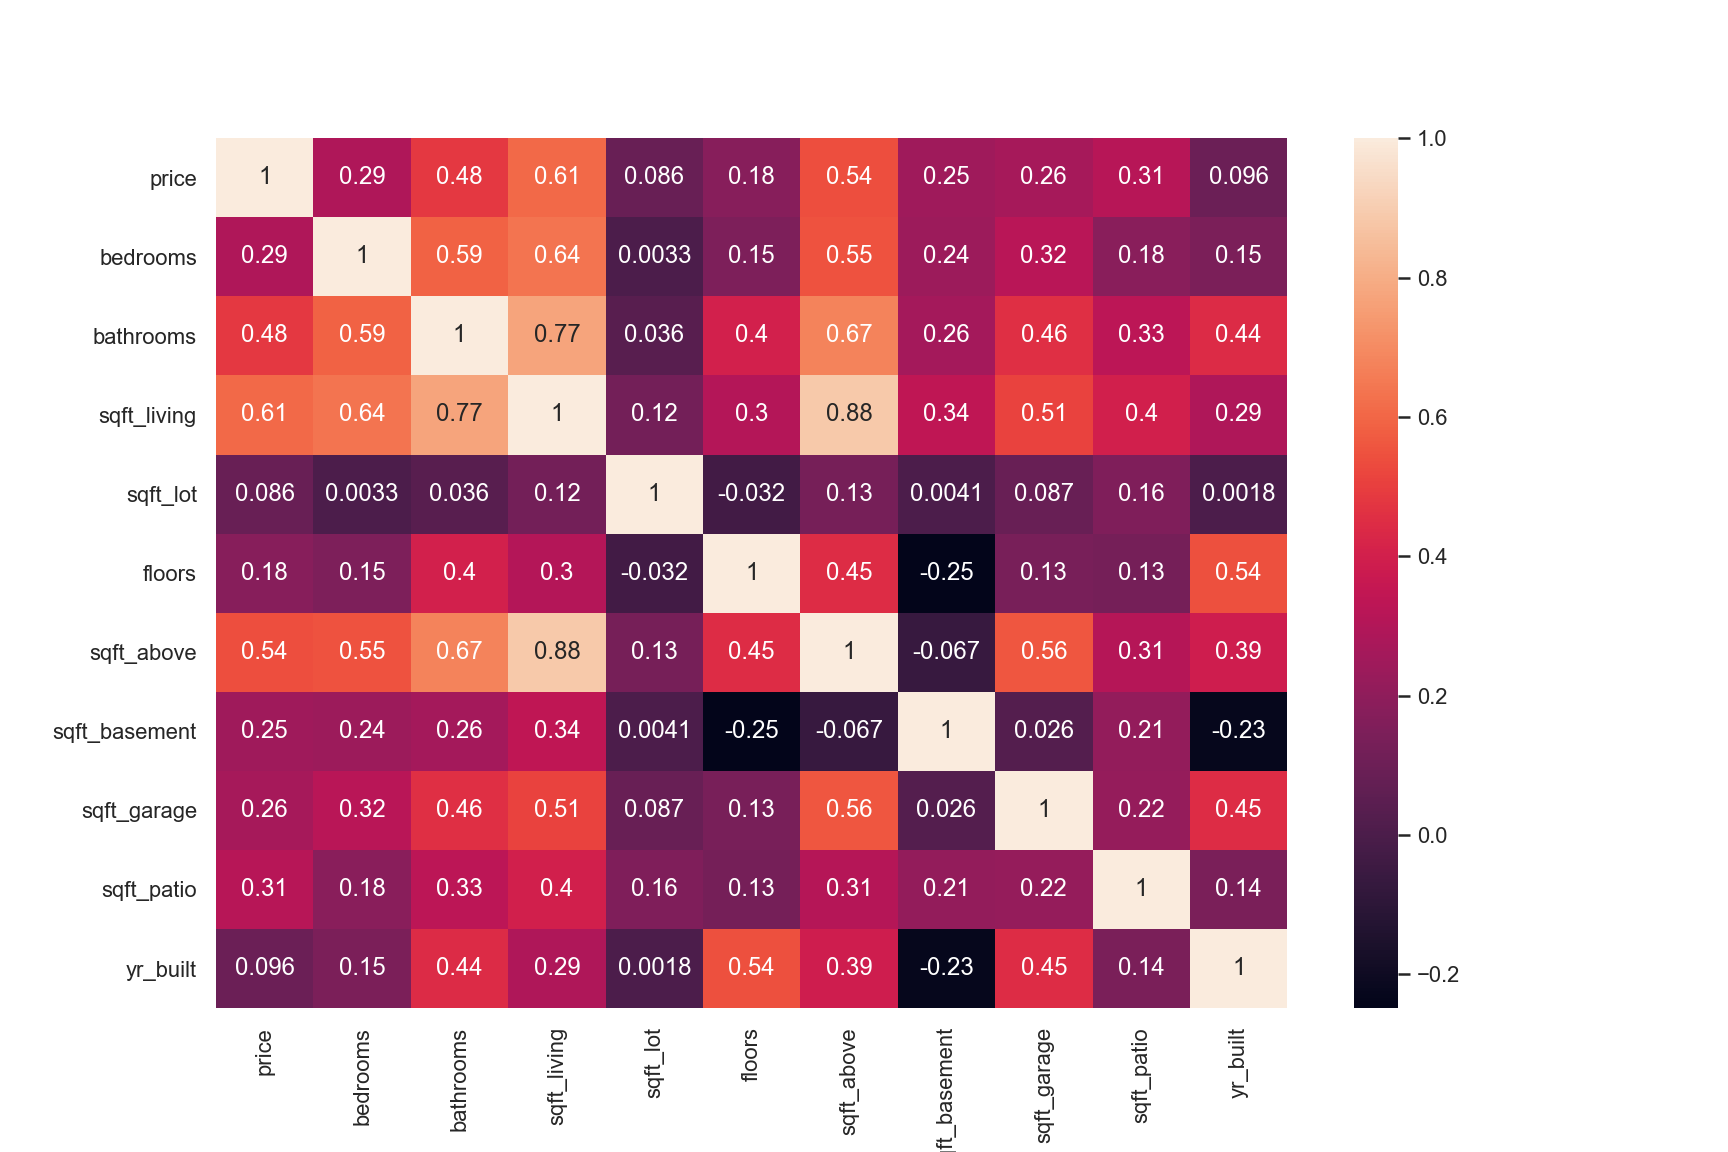

In [14]:

sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(data_pred.corr(), annot=True);

In [15]:
df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))

df.set_index(['pairs'], inplace = True)

df.drop(columns=['level_1', 'level_0'], inplace = True)

df.columns = ['cc']

df.drop_duplicates(inplace=True)


In [16]:
abs(df) > 0.75

,cc
pairs,
"(price, price)",True
"(sqft_living, sqft_above)",True
"(sqft_living, bathrooms)",True
"(bathrooms, sqft_above)",False
"(bedrooms, sqft_living)",False
"(price, sqft_living)",False
"(bedrooms, bathrooms)",False
"(sqft_garage, sqft_above)",False
"(bedrooms, sqft_above)",False


In [17]:
df[(df.cc>.75) & (df.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.883984
"(sqft_living, bathrooms)",0.772677


<p>The only pairs of features that have correlations higher than 0.75 are sqft_living and sqft_above, and sqft_living and bathrooms. This makes sense, because the square feet of the living area is likely a large portion of the square feet above ground for a house. </p>
<p>Also, it would make sense that the larger amount of square footage of living space, the higher number of bathrooms a house would have. Following this same logic, the 'bedrooms' feature would also likely cause multicollinearity.</p>
<p>Looking at the correlations, I see that the bedrooms and bathrooms features are more correlated with the feature 'sqft_living' than they are with price, so this indicates multicollinearity.
Because sqft_living is the most correlated with the target variable out of these, I am going to exclude the variables sqft_above, bedrooms, and bathrooms moving forward.</p>


#### Now, to look at the rest of the features:

I start by creating a new dataframe with only the features that I will be using:

In [18]:
data1 = data_all.copy()
data1 = data1[['price', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source', 'sewer_system']]
data1.head()

,price,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,heat_source,sewer_system
0,675000.0,1180,7140,1.0,NO,NO,NO,NONE,Gas,PUBLIC
1,920000.0,2770,6703,1.0,NO,NO,YES,AVERAGE,Oil,PUBLIC
2,311000.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Gas,PUBLIC
3,775000.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Gas,PUBLIC
4,592500.0,1120,758,2.0,NO,NO,YES,NONE,Electricity,PUBLIC


In [19]:
data1.corr()["price"]

price          1.000000
sqft_living    0.608521
sqft_lot       0.085730
floors         0.180576
Name: price, dtype: float64

Then, I create a dataframe of only the relevant $numeric$ variables, to further investigate them:

In [20]:
data_num = data1.copy().select_dtypes("number")
data_num.dropna(inplace=True)
data_num

,price,sqft_living,sqft_lot,floors
0,675000.0,1180,7140,1.0
1,920000.0,2770,6703,1.0
2,311000.0,2880,6156,1.0
3,775000.0,2160,1400,2.0
4,592500.0,1120,758,2.0
...,...,...,...,...
30150,1555000.0,1910,4000,1.5
30151,1313000.0,2020,5800,2.0
30152,800000.0,1620,3600,1.0
30153,775000.0,2570,2889,2.0


<IPython.core.display.Javascript object>


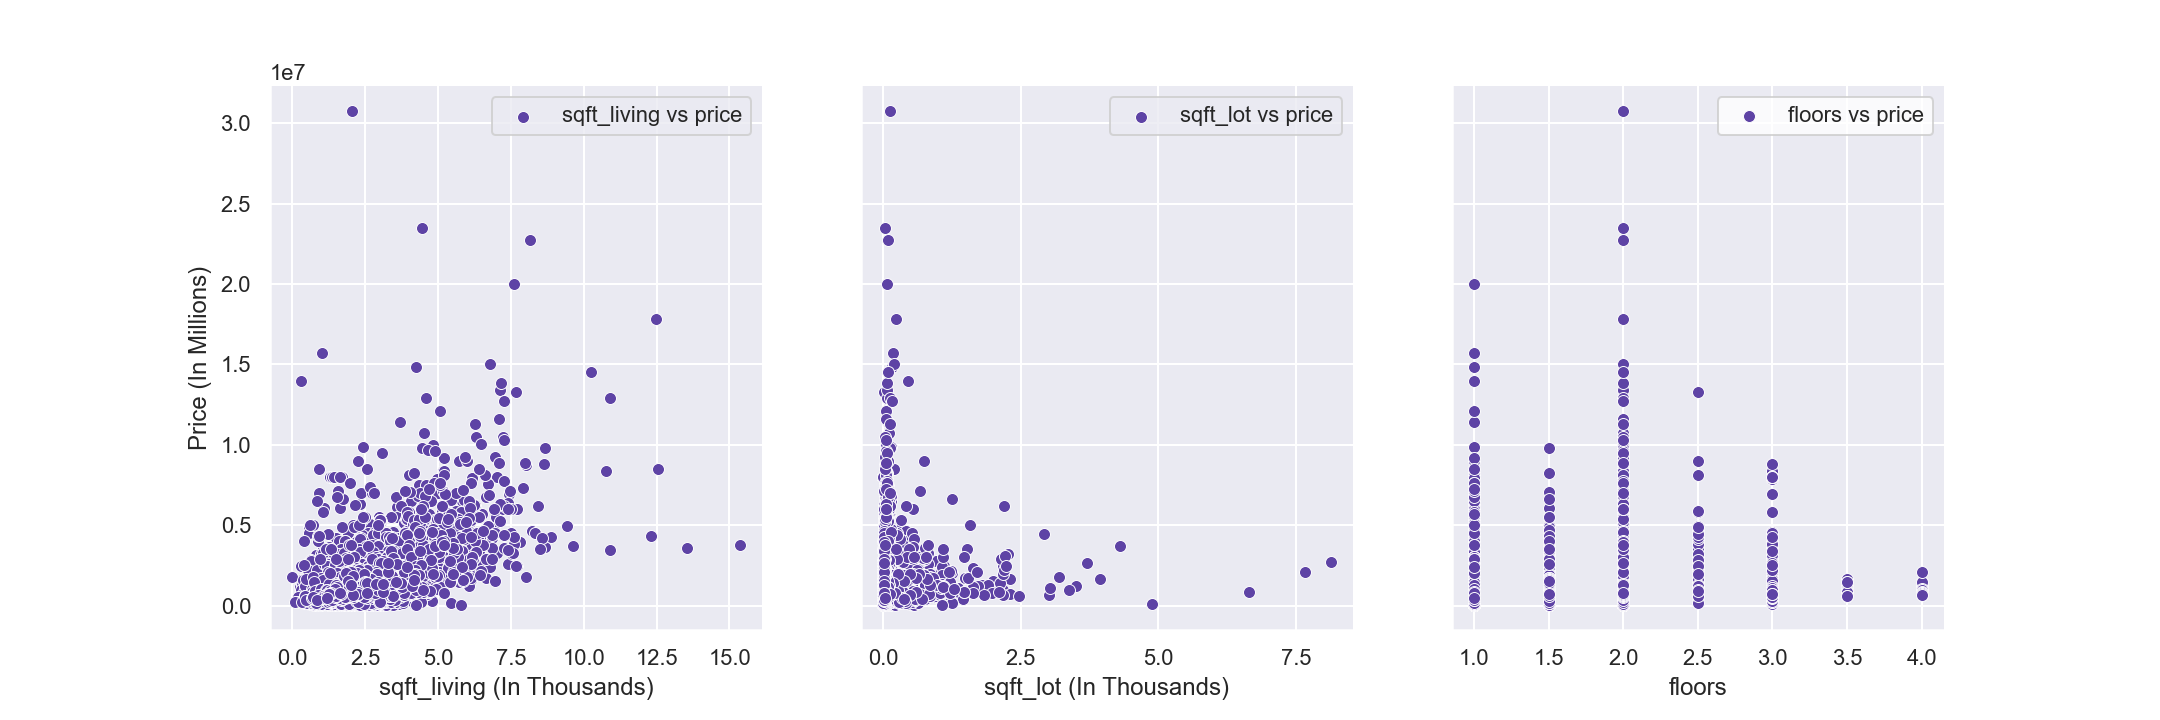

<ipython-input-21-9150ee68638b>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels)
<ipython-input-21-9150ee68638b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlabels)


In [21]:
import matplotlib.pyplot as plt
from matplotlib import ticker

sns.set_palette("twilight", 2)
# Plot scatterplots for multiple columns
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,5), sharey=True, nrows=1, ncols=3)
ax1 = sns.scatterplot(data = data_pred, x='sqft_living', y='price', label='sqft_living vs price', ax=ax1)
ax2 = sns.scatterplot(data = data_pred, x='sqft_lot', y='price', label='sqft_lot vs price', ax=ax2)
ax3 = sns.scatterplot(data = data_pred, x='floors', y='price', label='floors vs price', ax=ax3)

# A function can also be used directly as a formatter. The function must take
# two arguments: ``x`` for the tick value and ``pos`` for the tick position,
# and must return a ``str``. This creates a FuncFormatter automatically.
#setup(ax1, title="lambda x, pos: str(x-5)")
#ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("$%.2d")*1e-8)
#ylabels = ['${:,f}'.format(x) for x in ax1.get_xticks()]
#ax1.set_yticklabels(ylabels)
ax1.set_ylabel("Price (In Millions)")

xlabels = ['{:,.1f}'.format(x) for x in ax1.get_xticks()/1000]
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax1.set_xlabel("sqft_living (In Thousands)")
ax2.set_xlabel("sqft_lot (In Thousands)")

sns.set_style("whitegrid")
sns.despine()
plt.legend()
plt.show();

Of the numeric variables in the data, aside from those already removed, it looks like the feature most correlated with price and having the strongest linear relationship with price is sqft_living. Therefore, this seems like a good feature to use for the baseline model.

Scatterplot of just sqft_living vs. price:

<IPython.core.display.Javascript object>


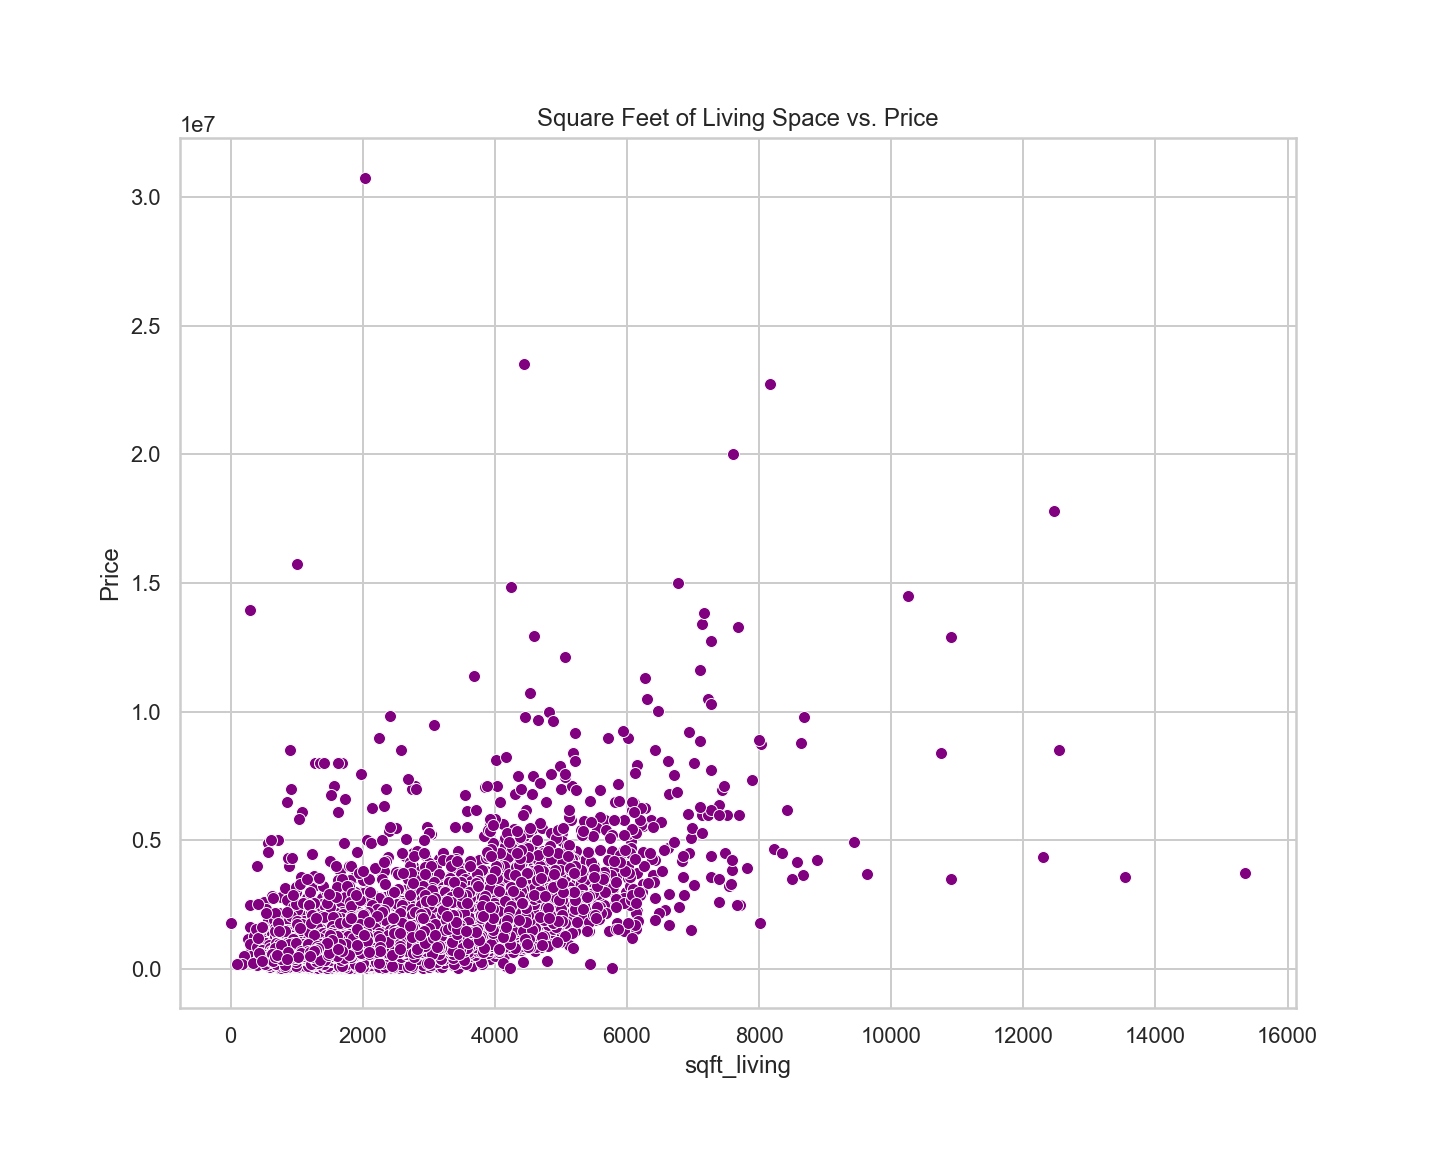

In [22]:
sns.set_style()
fig, ax = plt.subplots(figsize=(10,8))
g = sns.scatterplot(data=data_num, x='sqft_living', y='price', color="purple", ax=ax)
g.set_title("Square Feet of Living Space vs. Price")
g.set_ylabel("Price")
g.set_xlabel("sqft_living");

## Modeling

First, a baseline model is created using the variable sqft_living, as it is the most correlated with sale price, to compare all other models to.

In [23]:
y = data1[['price']]
X_baseline = data1[['sqft_living']]

###### Baseline results:

In [24]:
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 1.773e+04
Date:                Mon, 12 Jun 2023   Prob (F-statistic):               0.00
Time:                        13:05:20   Log-Likelihood:            -4.4912e+05
No. Observations:               30155   AIC:                         8.982e+05
Df Residuals:                   30153   BIC:                         8.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.443e+04   9782.728     -7.609      

In [25]:
baseline_results.pvalues

const          2.852024e-14
sqft_living    0.000000e+00
dtype: float64

##### Plotting the actual vs. predicted values of this model:

<IPython.core.display.Javascript object>


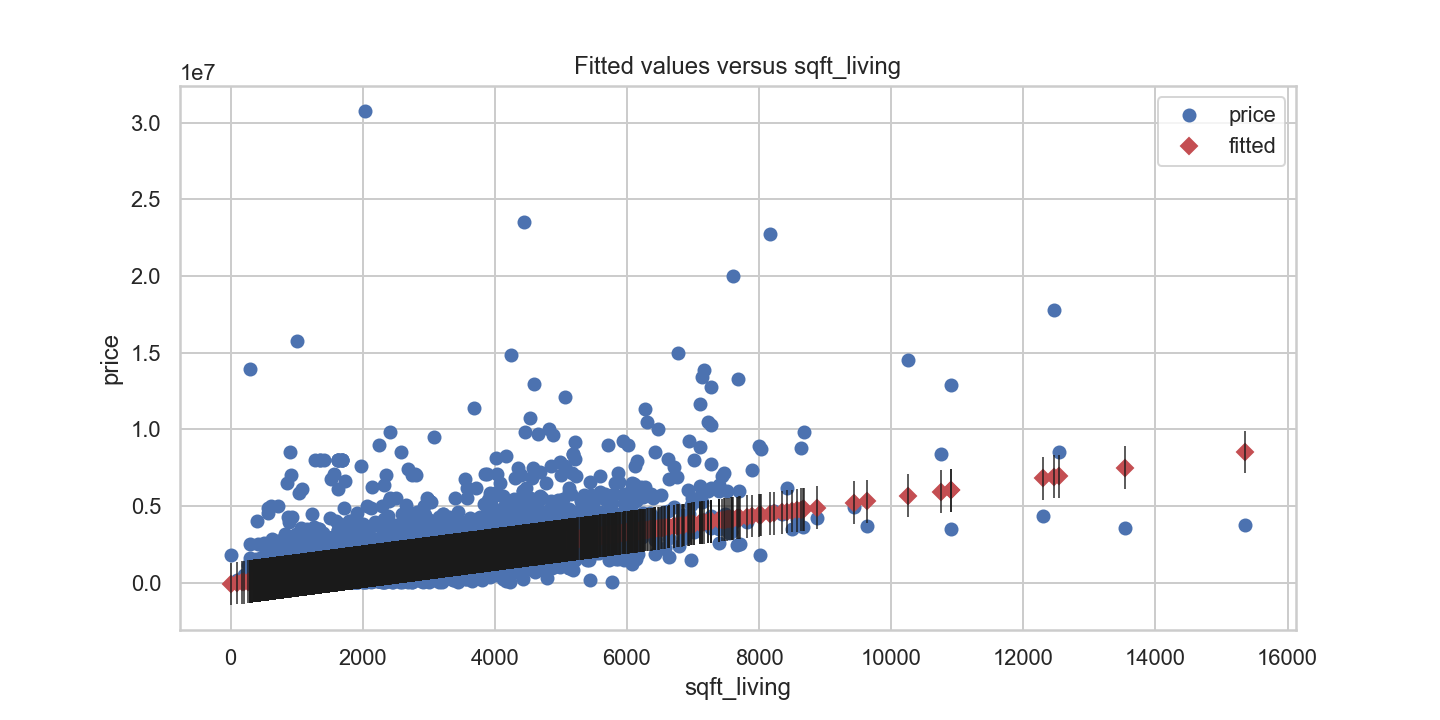

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
sm.graphics.plot_fit(baseline_results, "sqft_living", ax=ax)
plt.show()

This shows the true (blue) vs. predicted (red) values, with the particular predictor (in this case, `sqft_living`) along the x-axis. 

##### Plotting the regression line:

<IPython.core.display.Javascript object>


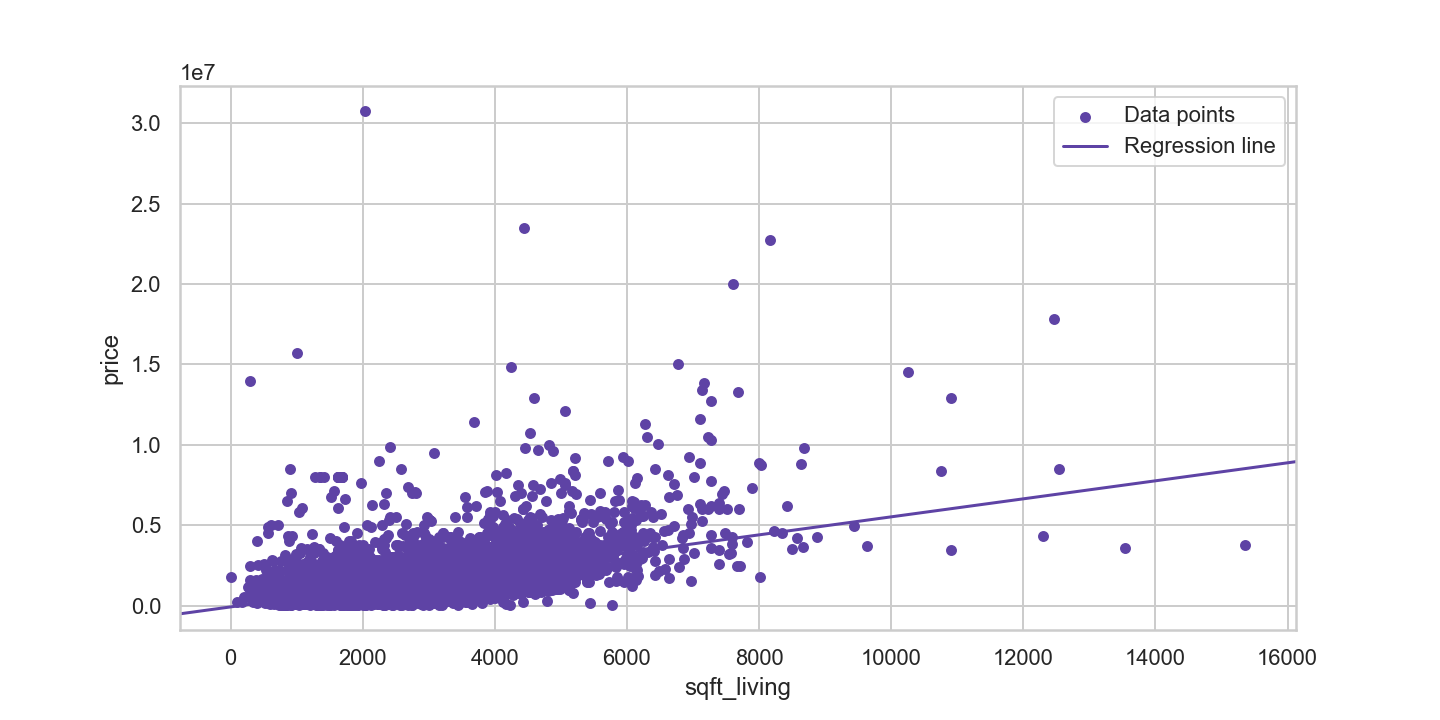

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1010: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1010: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


In [27]:
fig, ax = plt.subplots(figsize=(10,5))
data1.plot.scatter(x="sqft_living", y="price", label="Data points", ax=ax)
sm.graphics.abline_plot(model_results=baseline_results, label="Regression line", ax=ax)
ax.legend();

This linear regression plot shows the the data points for the predictor, sqft_living, against price.

##### Plotting the residuals:

<IPython.core.display.Javascript object>


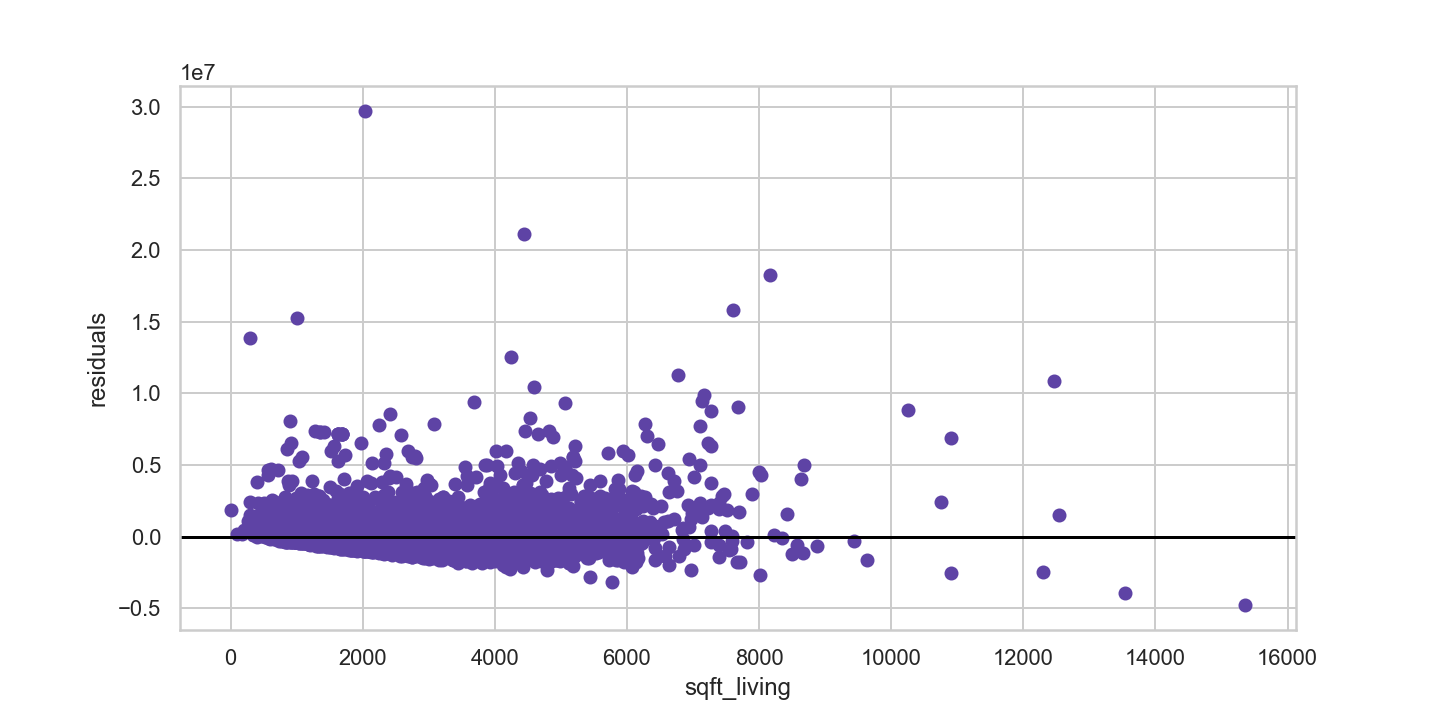

In [28]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(data1["sqft_living"], baseline_results.resid)
ax.axhline(y=0, color="black")
ax.set_xlabel("sqft_living")
ax.set_ylabel("residuals");

The model residuals are the <em>differences</em> between the actual and predicted values. From this plot, it looks like this model guessed values too high more often than it guessed them too low.

### Numeric data:

Now, to add all of the numeric features to a multiple linear regression to see if it improves our model:

In [29]:
X_all = data1.drop(['price'], axis=1).select_dtypes("number")
X_all

,sqft_living,sqft_lot,floors
0,1180,7140,1.0
1,2770,6703,1.0
2,2880,6156,1.0
3,2160,1400,2.0
4,1120,758,2.0
...,...,...,...
30150,1910,4000,1.5
30151,2020,5800,2.0
30152,1620,3600,1.0
30153,2570,2889,2.0


#### Results for all numeric variables:

In [30]:
model = sm.OLS(y, sm.add_constant(X_all))
results_allnum = model.fit()

print(results_allnum.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5915.
Date:                Mon, 12 Jun 2023   Prob (F-statistic):               0.00
Time:                        13:05:42   Log-Likelihood:            -4.4912e+05
No. Observations:               30155   AIC:                         8.982e+05
Df Residuals:                   30151   BIC:                         8.983e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.716e+04   1.32e+04     -5.083      

<IPython.core.display.Javascript object>


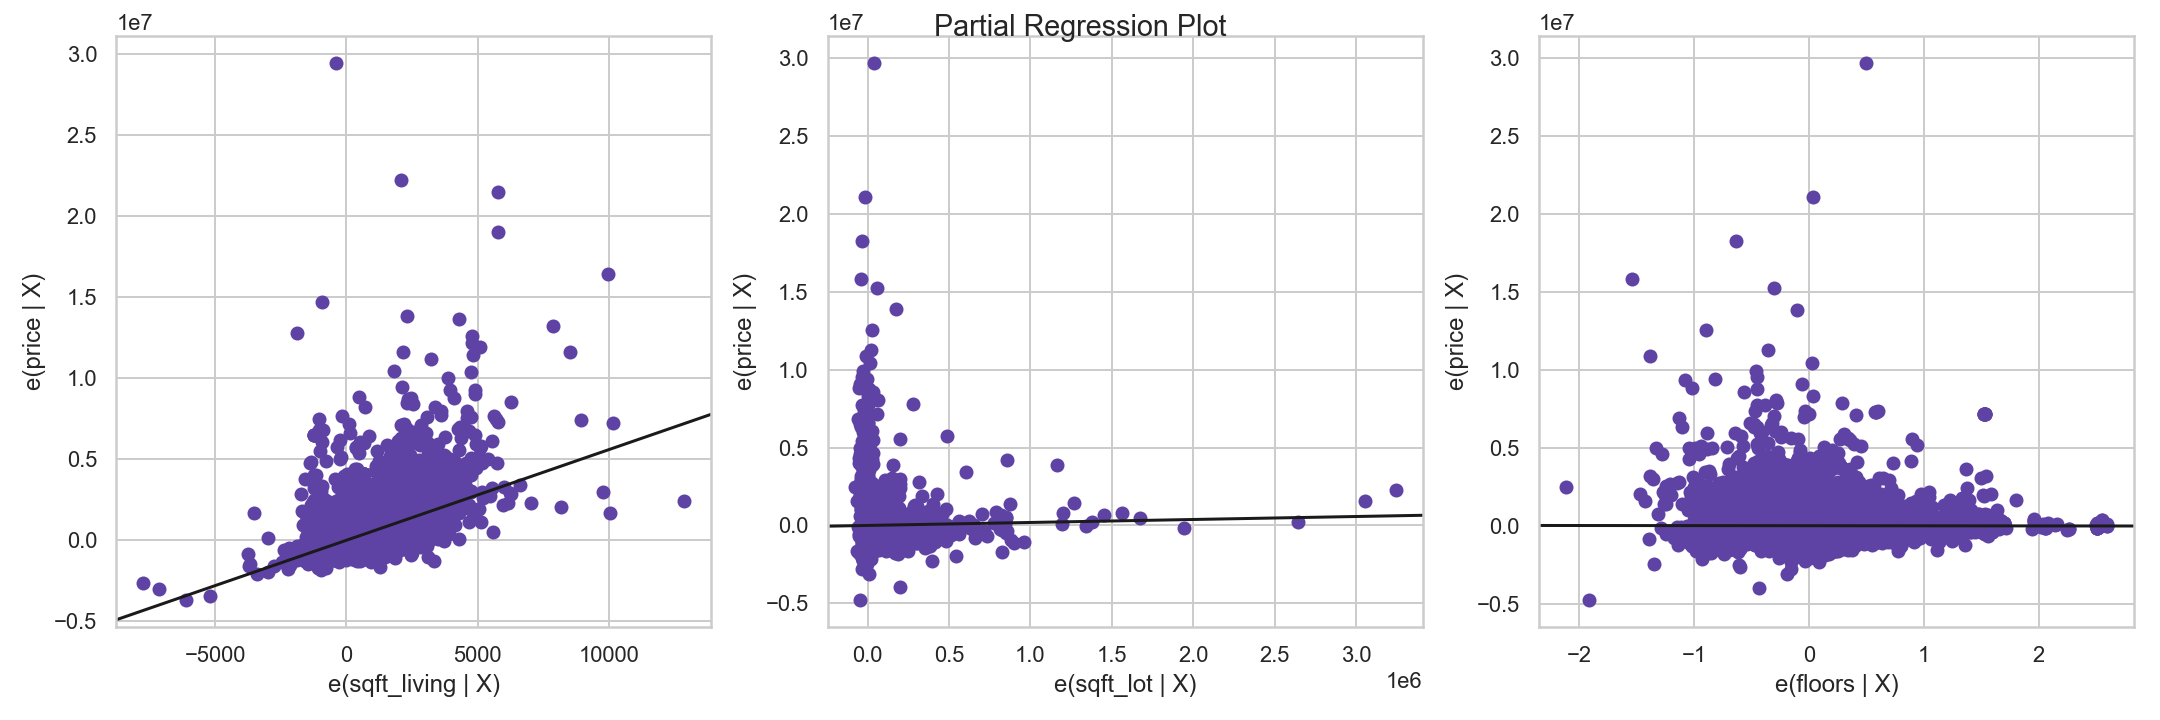

In [31]:
fig = plt.figure(figsize=(15,5))
sm.graphics.plot_partregress_grid(
    results_allnum,
    exog_idx=list(X_all.columns.values),
    grid=(1,3),
    fig=fig)

plt.show();

These models look worse than the initial scatterplots, so likely we included too many features. Since the numeric features of sqft_lot, and floors do not appear to have a positive linear relationship with price, we will remove those features.

### Categorical data:

Now, before the categorical variables can be modeled, they will need to be transformed using one-hot encoding.

In [32]:
X_wf = data1[["waterfront"]]
X_gb = data1[["greenbelt"]]
X_nu = data1[["nuisance"]]
X_vw = data1[["view"]]

#### 'waterfront' feature:

<IPython.core.display.Javascript object>


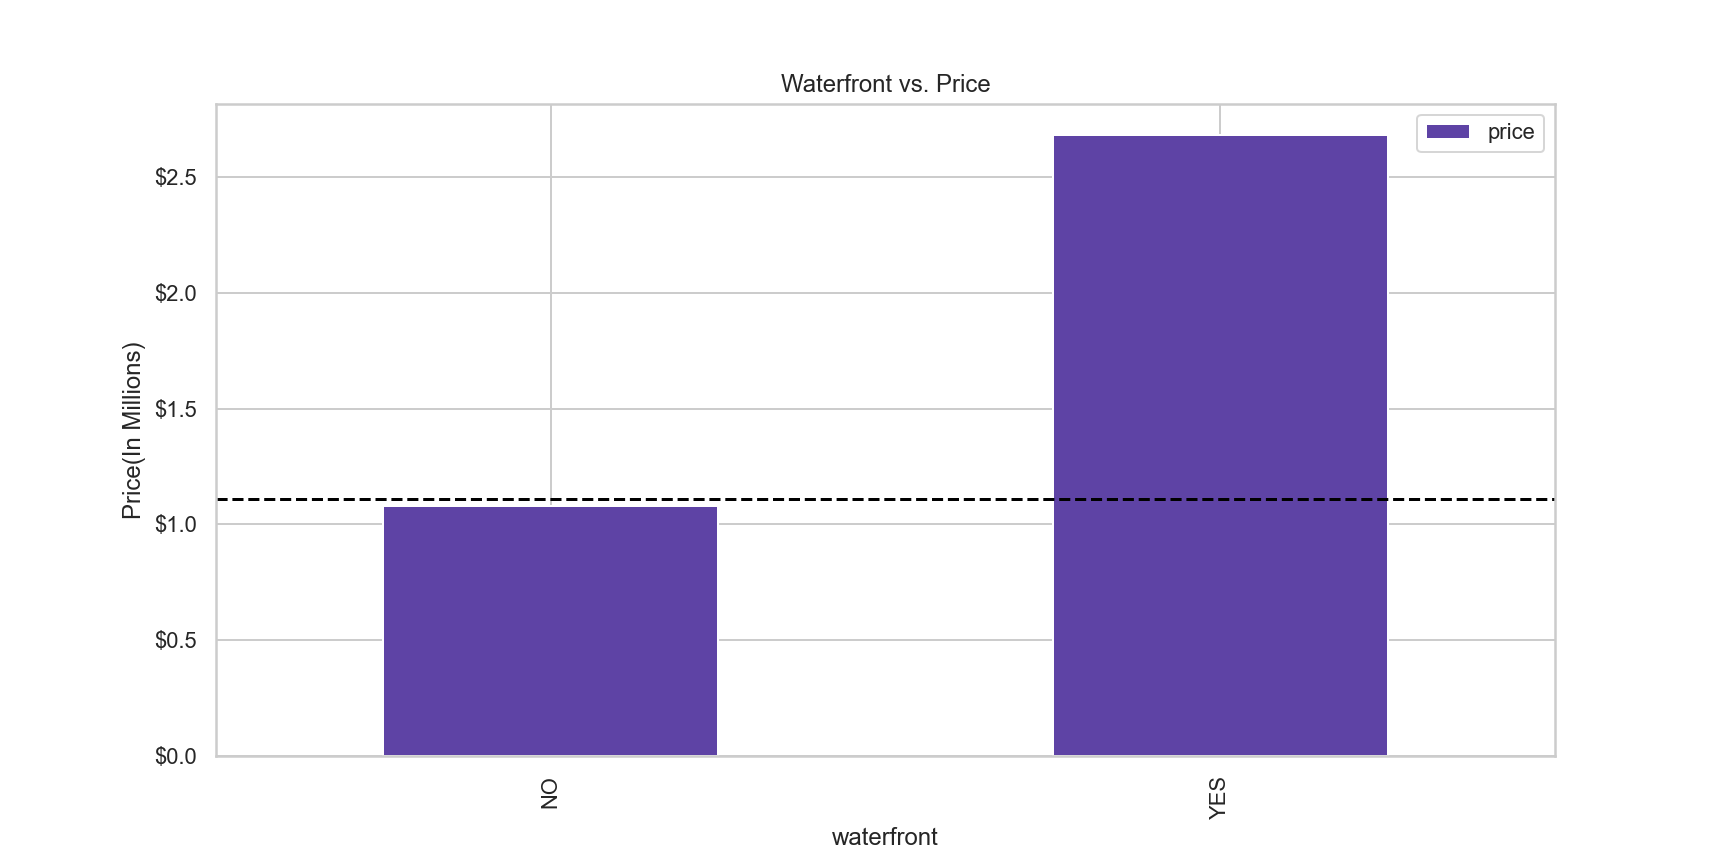

<ipython-input-33-052e0b7bcb93>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels);


In [33]:
fig, ax = plt.subplots(figsize=(12,6))
data1.groupby("waterfront").mean().plot.bar(y="price", ax=ax).set(ylabel="Price(In Millions)", title="Waterfront vs. Price")
ax.axhline(y=data1["price"].mean(), label="mean", color="black", linestyle="--")
ylabels = ['${:,.1f}'.format(x) for x in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels);


In [34]:
waterfront_X = pd.get_dummies(X_wf, columns=["waterfront"], drop_first=True)
waterfront_X

,waterfront_YES
0,0
1,0
2,0
3,0
4,0
...,...
30150,0
30151,0
30152,0
30153,0


In [35]:
waterfront_model = sm.OLS(y, sm.add_constant(waterfront_X))
wf_results = waterfront_model.fit()

print(wf_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1719.
Date:                Mon, 12 Jun 2023   Prob (F-statistic):               0.00
Time:                        13:06:21   Log-Likelihood:            -4.5526e+05
No. Observations:               30155   AIC:                         9.105e+05
Df Residuals:                   30153   BIC:                         9.105e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.081e+06   5064.675    213.

##### Interpretation:
This model is statistically significant and explains about 5.4% of the variance in price.
Compared to a house that is not on a waterfront, for a house with a waterfront we see an associated increase of about $1,601,000 in price.

#### 'greenbelt' feature:

<IPython.core.display.Javascript object>


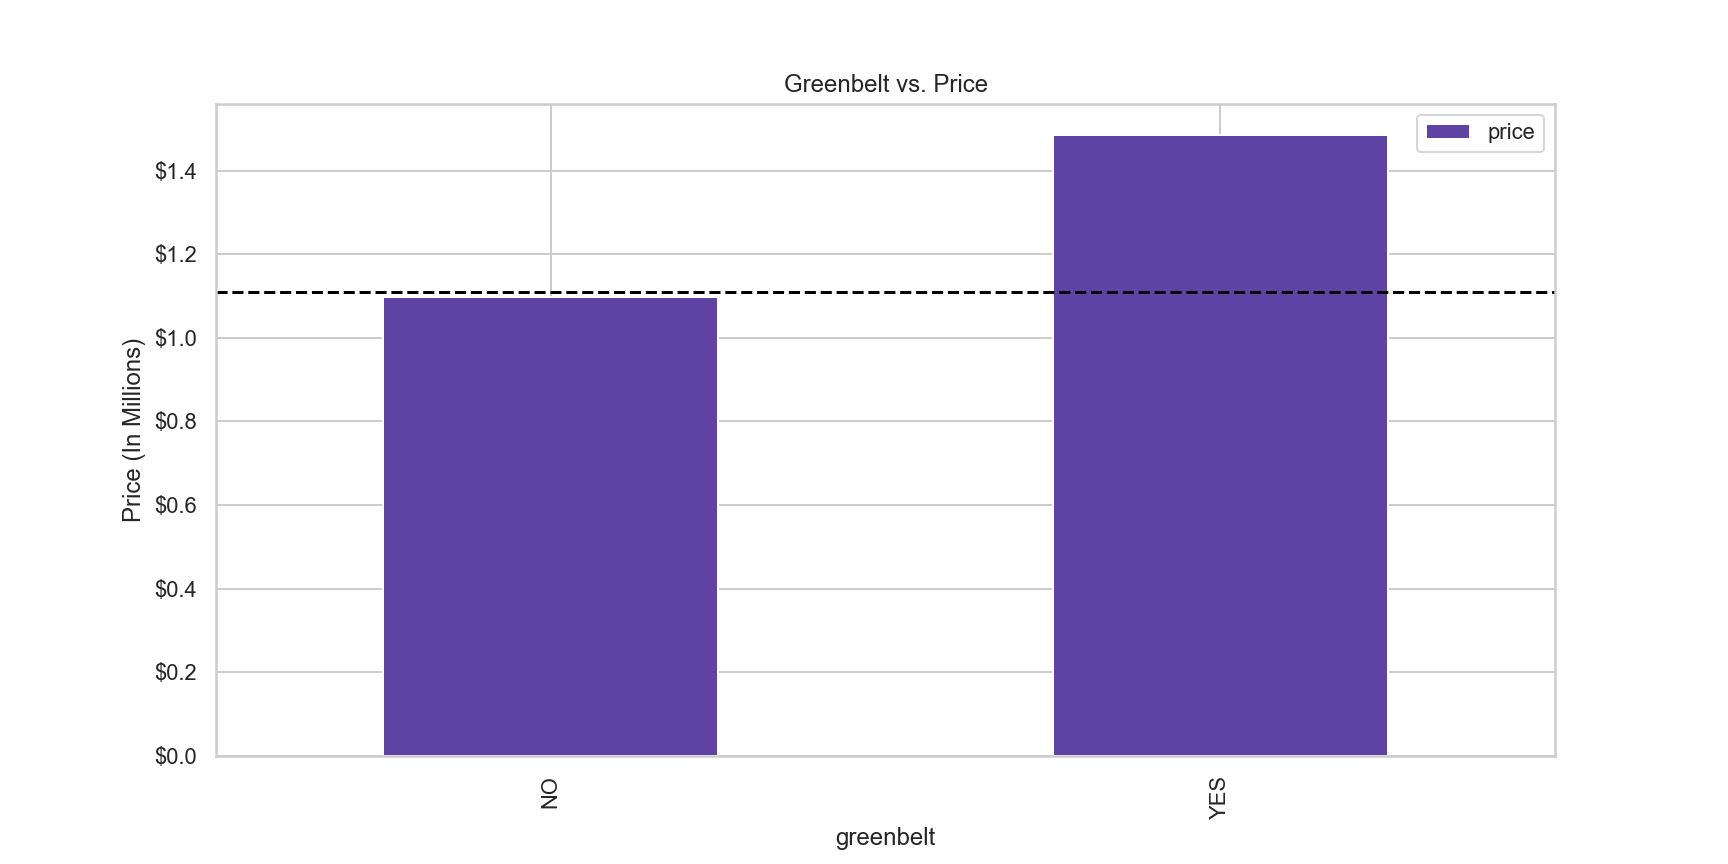

<ipython-input-36-5d4b2b7c76a6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels);


In [36]:
fig, ax = plt.subplots(figsize=(12,6))
data1.groupby("greenbelt").mean().plot.bar(y="price", ax=ax).set(ylabel="Price (In Millions)", title="Greenbelt vs. Price")
ax.axhline(y=data1["price"].mean(), label="mean", color="black", linestyle="--")
ylabels = ['${:,.1f}'.format(x) for x in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels);

In [37]:
greenbelt_X = pd.get_dummies(X_gb, columns=["greenbelt"], drop_first=True)
greenbelt_X

,greenbelt_YES
0,0
1,0
2,0
3,0
4,0
...,...
30150,0
30151,0
30152,0
30153,0


In [38]:
greenbelt_model = sm.OLS(y, sm.add_constant(greenbelt_X))
gb_results = greenbelt_model.fit()

print(gb_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     141.1
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           1.77e-32
Time:                        13:06:26   Log-Likelihood:            -4.5603e+05
No. Observations:               30155   AIC:                         9.121e+05
Df Residuals:                   30153   BIC:                         9.121e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.099e+06   5217.319    210.570

##### Interpretation:
This model is statistically significant and explains about 0.5% of the variance in price
Compared to a house that is not near a greenbelt, for a house that is near a greenbelt we see an associated increase of about $387,100 in price.

#### 'nuisance' feature:

<IPython.core.display.Javascript object>


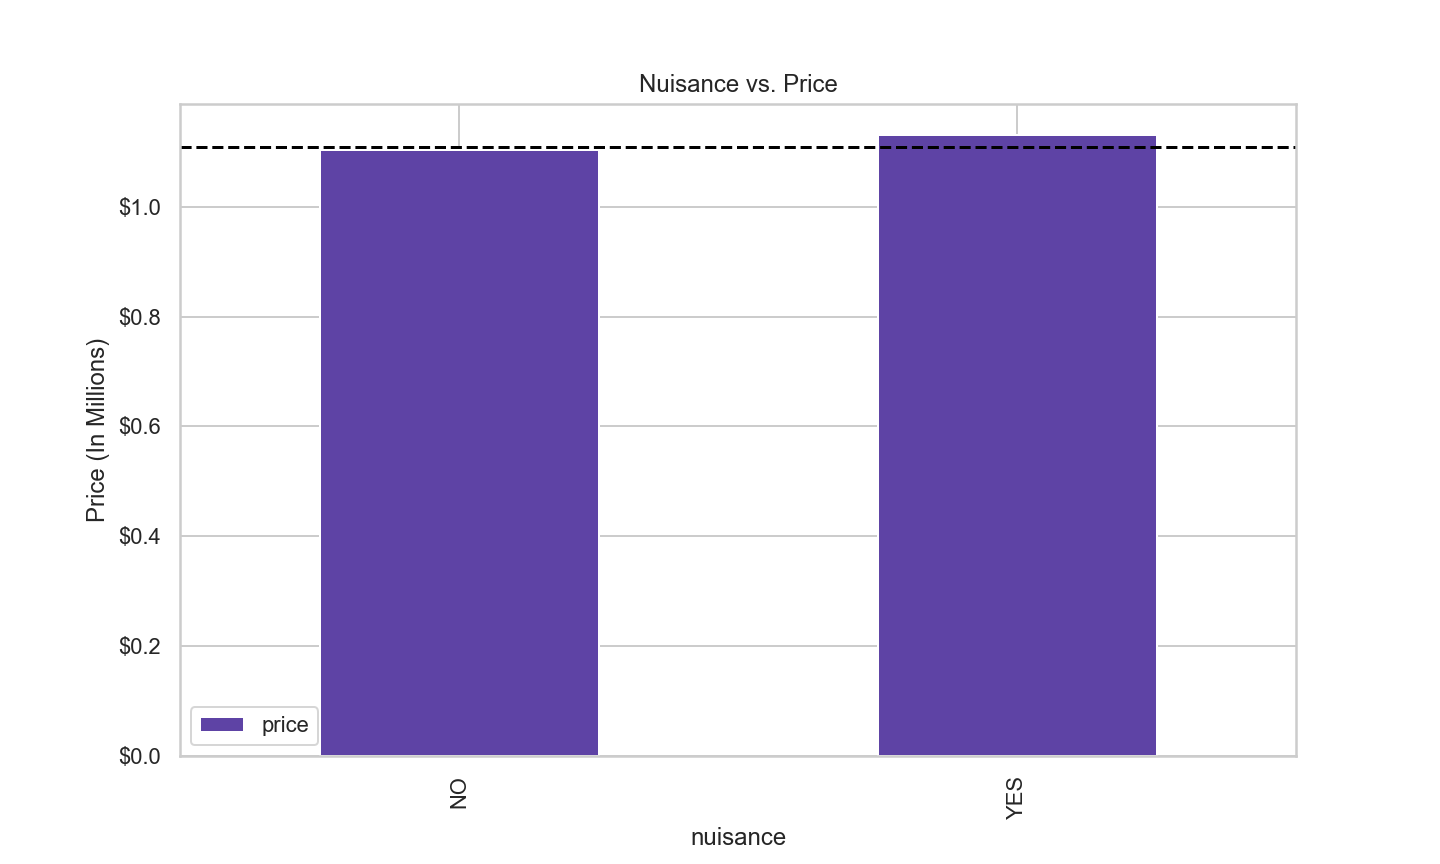

<ipython-input-39-d7fc6cb13915>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels);


In [39]:
fig, ax = plt.subplots(figsize=(10,6))
data1.groupby("nuisance").mean().plot.bar(y="price", ax=ax).set(ylabel="Price (In Millions)", title="Nuisance vs. Price")
ax.axhline(y=data1["price"].mean(), label="mean", color="black", linestyle="--")
ylabels = ['${:,.1f}'.format(x) for x in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels);

In [40]:
nuisance_X = pd.get_dummies(X_nu, columns=["nuisance"], drop_first=True)
nuisance_X

,nuisance_YES
0,0
1,1
2,0
3,0
4,1
...,...
30150,0
30151,0
30152,1
30153,0


In [41]:
nuisance_model = sm.OLS(y, sm.add_constant(nuisance_X))
nu_results = nuisance_model.fit()

print(nu_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.021
Date:                Mon, 12 Jun 2023   Prob (F-statistic):             0.0449
Time:                        13:06:31   Log-Likelihood:            -4.5609e+05
No. Observations:               30155   AIC:                         9.122e+05
Df Residuals:                   30153   BIC:                         9.122e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.104e+06   5681.127    194.288   

##### Interpretation:
This model is not statistically significant and it explains 0% of the variance in price. This indicates that this model is not a good model to use to predict price and it may not be suited for linear regression.

#### 'view' feature:

<IPython.core.display.Javascript object>


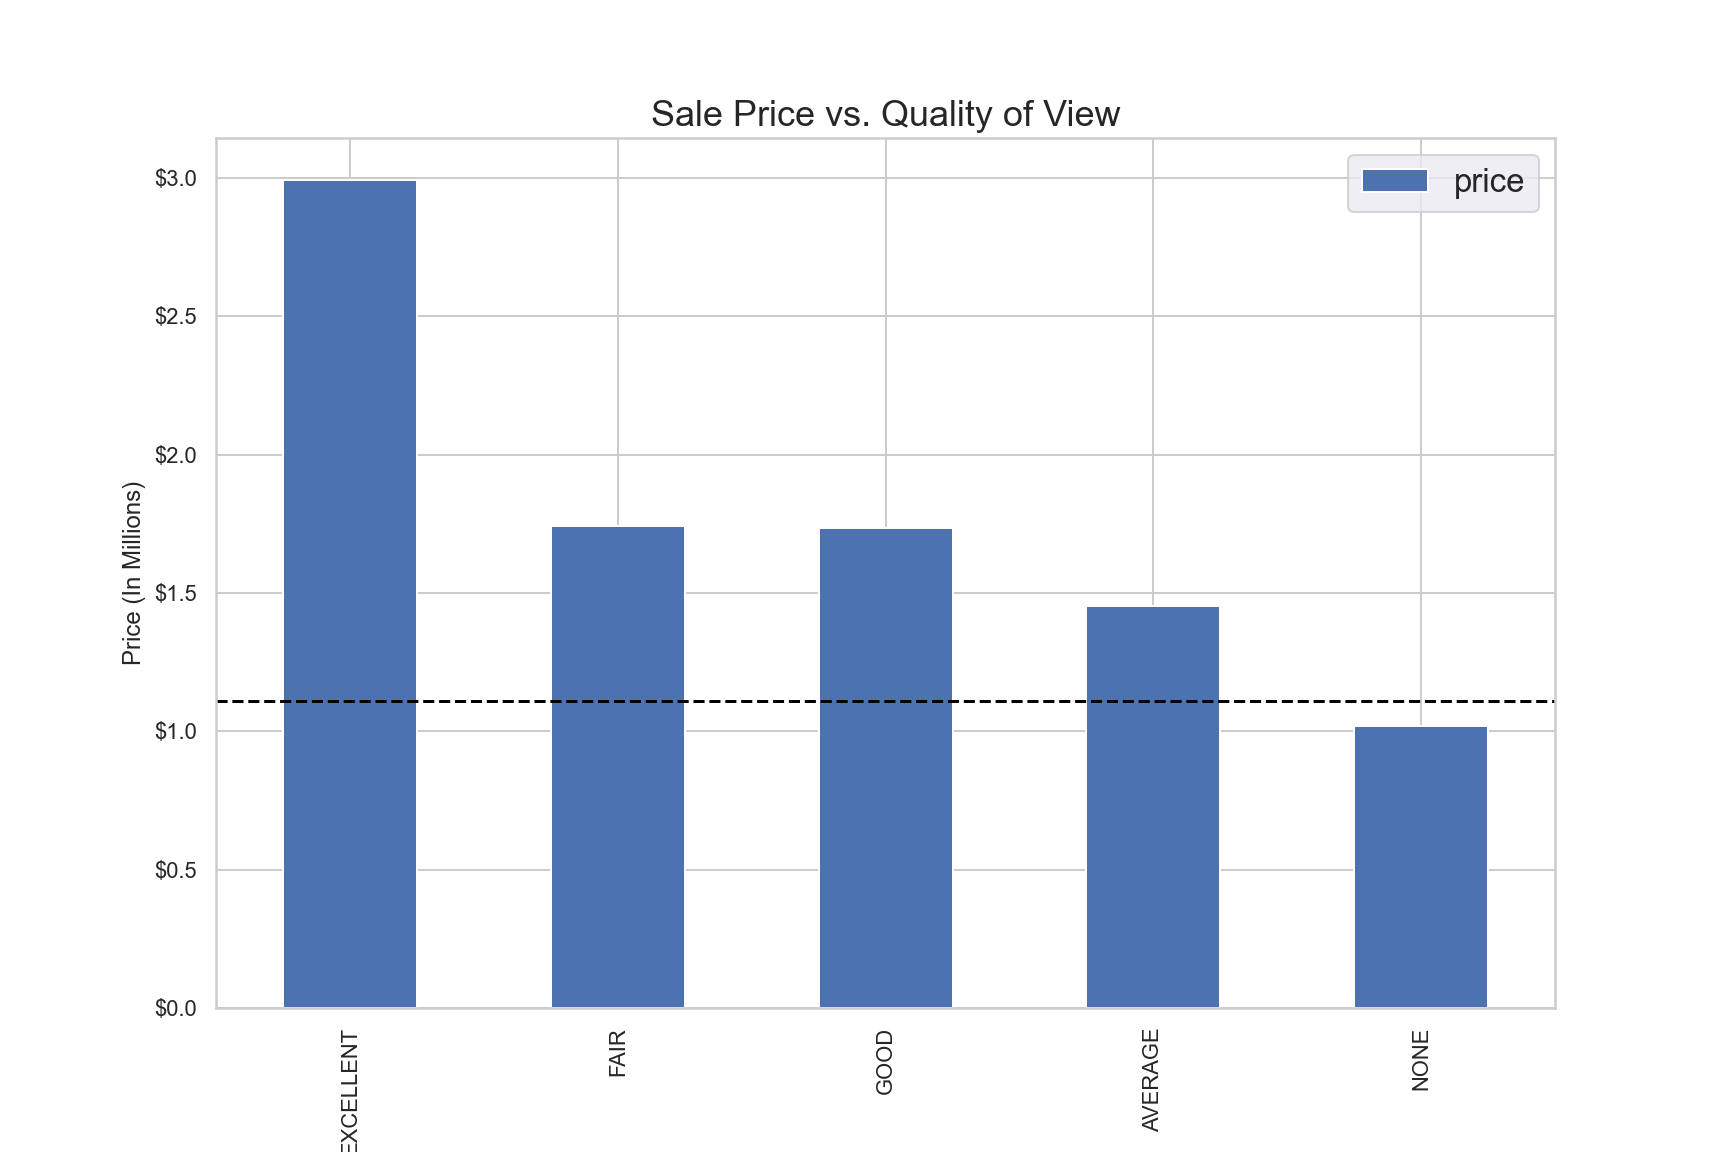

<ipython-input-42-27b42950445d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels);


In [42]:
fig, ax = plt.subplots(figsize=(12,8))

sns.set(font_scale=1.5)
#sns.barplot(data=data1, x='view', y='price')
data1.groupby("view").mean().sort_values("price",ascending=False).plot.bar(y="price", ax=ax).set(ylabel="Price (In Millions)", xlabel="View Quality", title="Sale Price vs. Quality of View")
ax.axhline(y=data1["price"].mean(), label="mean", color="black", linestyle="--")
ylabels = ['${:,.1f}'.format(x) for x in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels);

<IPython.core.display.Javascript object>


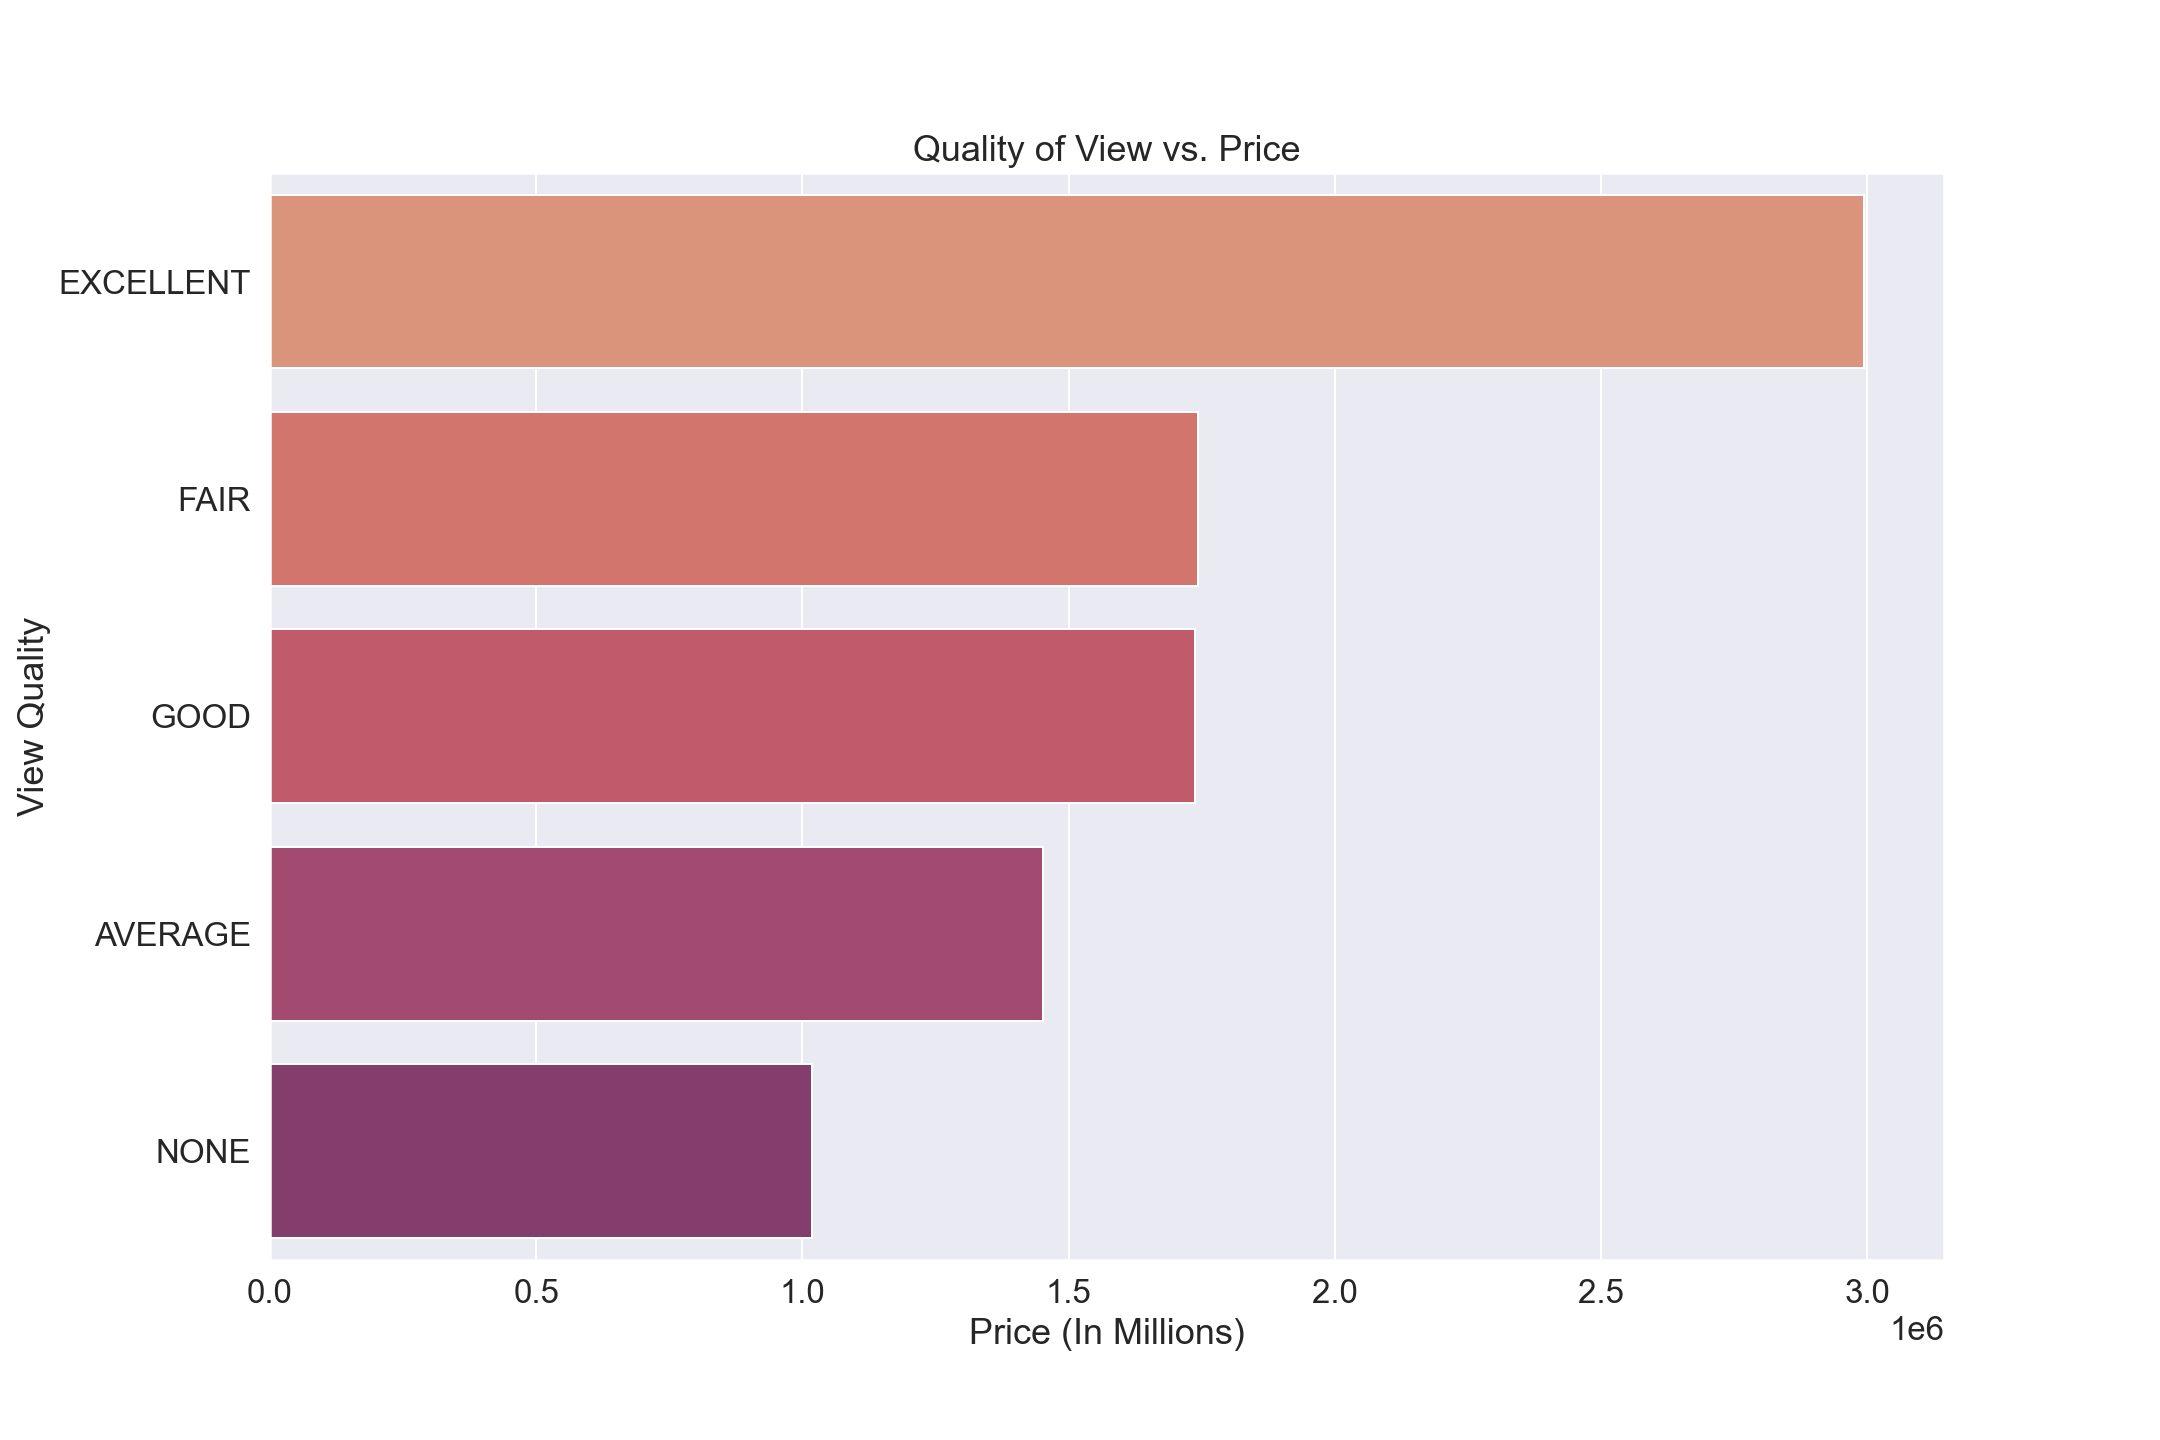

In [43]:
view_sorted = data1.groupby("view").mean().sort_values("price",ascending=False).reset_index()
sns.set_palette('flare')
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=view_sorted, x="price", y="view", orient='h').set(xlabel="Price (In Millions)", ylabel="View Quality", title="Quality of View vs. Price");

In [44]:
view_X = pd.get_dummies(X_vw, columns=["view"], drop_first=True)
view_X

,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
0,0,0,0,1
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,1
...,...,...,...,...
30150,0,0,0,1
30151,0,1,0,0
30152,0,0,0,1
30153,0,0,0,1


In [45]:
view_model = sm.OLS(y, sm.add_constant(view_X))
vw_results = view_model.fit()

print(vw_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     1001.
Date:                Mon, 12 Jun 2023   Prob (F-statistic):               0.00
Time:                        13:07:45   Log-Likelihood:            -4.5421e+05
No. Observations:               30155   AIC:                         9.084e+05
Df Residuals:                   30150   BIC:                         9.085e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.452e+06   1.92e+04     75.

##### Interpretation:
This model is statistically signficant and it explains about 11.7% of the variance in price.
Compared to a house with an average view, we see an associated increase of about 1,542,000 dollars in price for a house with an excellent view, an increase of about 284,400 dollars in price for a house with a good view, an increase of about 290,100 dollars for a house with a fair view, and a <b>decrease</b> of about 433,400 dollars for a house with no view.

Of the categorical variables, the one that appears to be the best predictors of price is <b>view</b>.

## Regression Results

### Creating a multiple regression model with sqft_living and view:

Since 'view' is the categorical variable that seems to be the best predictor of price, I am going to add it to a model with sqft_living to see if it is an improvement to the baseline.

In [46]:
multi_x = data1[['sqft_living', 'view']]

In [47]:
multi_x_forvis = pd.get_dummies(multi_x, columns=["view"]).drop('sqft_living', axis=1)
multi_x_forvis

,view_AVERAGE,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
0,0,0,0,0,1
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
30150,0,0,0,0,1
30151,0,0,1,0,0
30152,0,0,0,0,1
30153,0,0,0,0,1


In [48]:
multi_x = pd.get_dummies(multi_x, columns=["view"], drop_first=True)
multi_x

,sqft_living,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE
0,1180,0,0,0,1
1,2770,0,0,0,0
2,2880,0,0,0,0
3,2160,0,0,0,0
4,1120,0,0,0,1
...,...,...,...,...,...
30150,1910,0,0,0,1
30151,2020,0,1,0,0
30152,1620,0,0,0,1
30153,2570,0,0,0,1


#### Multiple linear regression results:

In [49]:
multi_model = sm.OLS(y, sm.add_constant(multi_x))
multi_results = multi_model.fit()

print(multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     4289.
Date:                Mon, 12 Jun 2023   Prob (F-statistic):               0.00
Time:                        13:08:10   Log-Likelihood:            -4.4800e+05
No. Observations:               30155   AIC:                         8.960e+05
Df Residuals:                   30149   BIC:                         8.961e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1.48e+05   1.89e+04      7.

In [50]:
multi_results.pvalues

const              4.313516e-15
sqft_living        0.000000e+00
view_EXCELLENT    1.714013e-278
view_FAIR          3.662044e-06
view_GOOD          1.512205e-03
view_NONE          7.013998e-29
dtype: float64

###### Interpretation:
This model is statistically significant and explains about 41.6% of the variance in price, which is an improvement from the baseline model that only explained about 37%.

For each increase by 1 square foot of living space, we expect to see an increase in price of about 521 dollars.
Compared to a house with an average view, for a house with an excellent view we see an associated increase in price of about of about 1,196,00 dollars. 
For a house with a good view, we see an associated increase in price of aboutof about 88,750 dollars. 
For a house with a fair view, we see an associated increase in price of about 225,900 dollars.
For a house with no view, we see an associated decrease in price of about 182,400 dollars.

#### Multiple Linear Regression Visualization:

##### Plotting the actual vs. predicted values of this model:

<IPython.core.display.Javascript object>


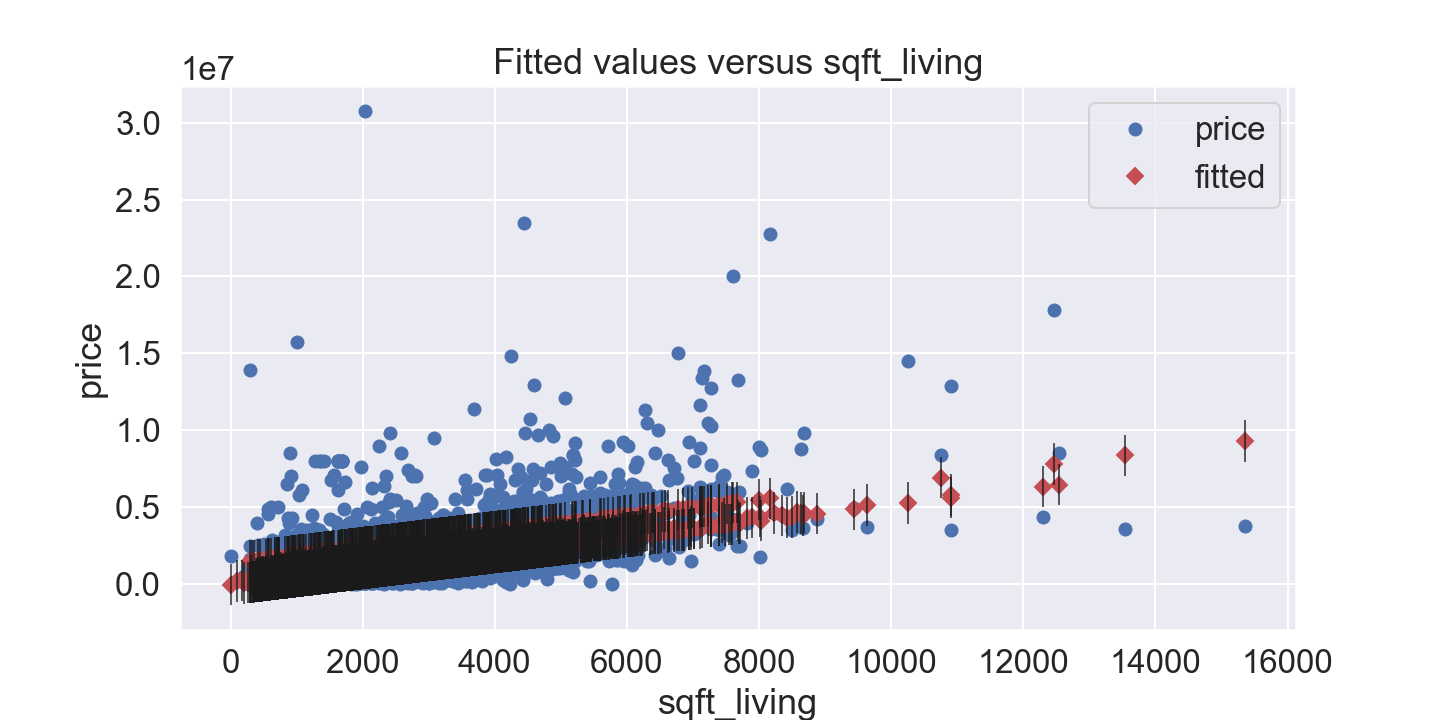

In [51]:
fig, ax = plt.subplots(figsize=(10,5))
sm.graphics.plot_fit(multi_results, "sqft_living", ax=ax)
plt.show()

This shows the true (blue) vs. predicted (red) values, with the particular predictor (in this case, `sqft_living`) along the x-axis. 

<IPython.core.display.Javascript object>


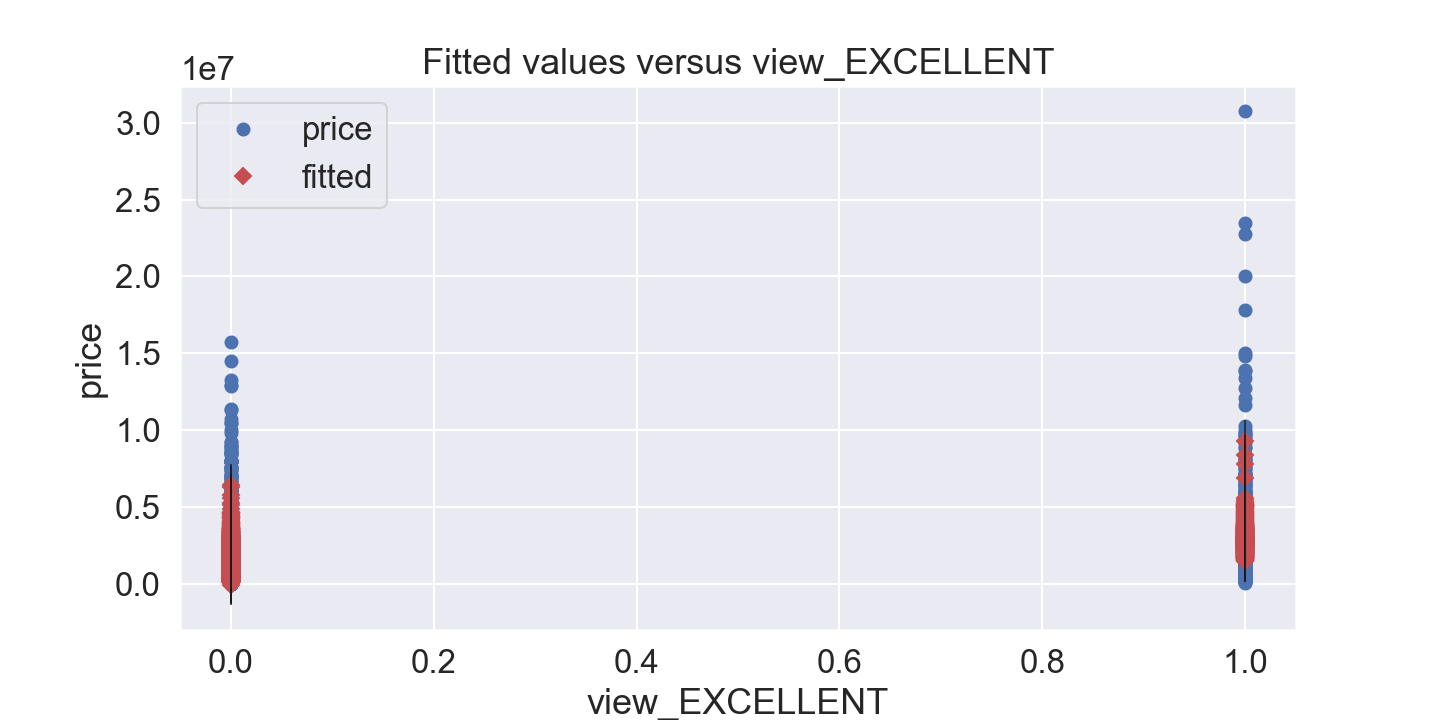

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
sm.graphics.plot_fit(multi_results, "view_EXCELLENT", ax=ax)
plt.show()

This shows the true (blue) vs. predicted (red) values, with the particular predictor (in this case, `view_EXCELLENT`) along the x-axis. 


##### Plotting the regression line:

<IPython.core.display.Javascript object>


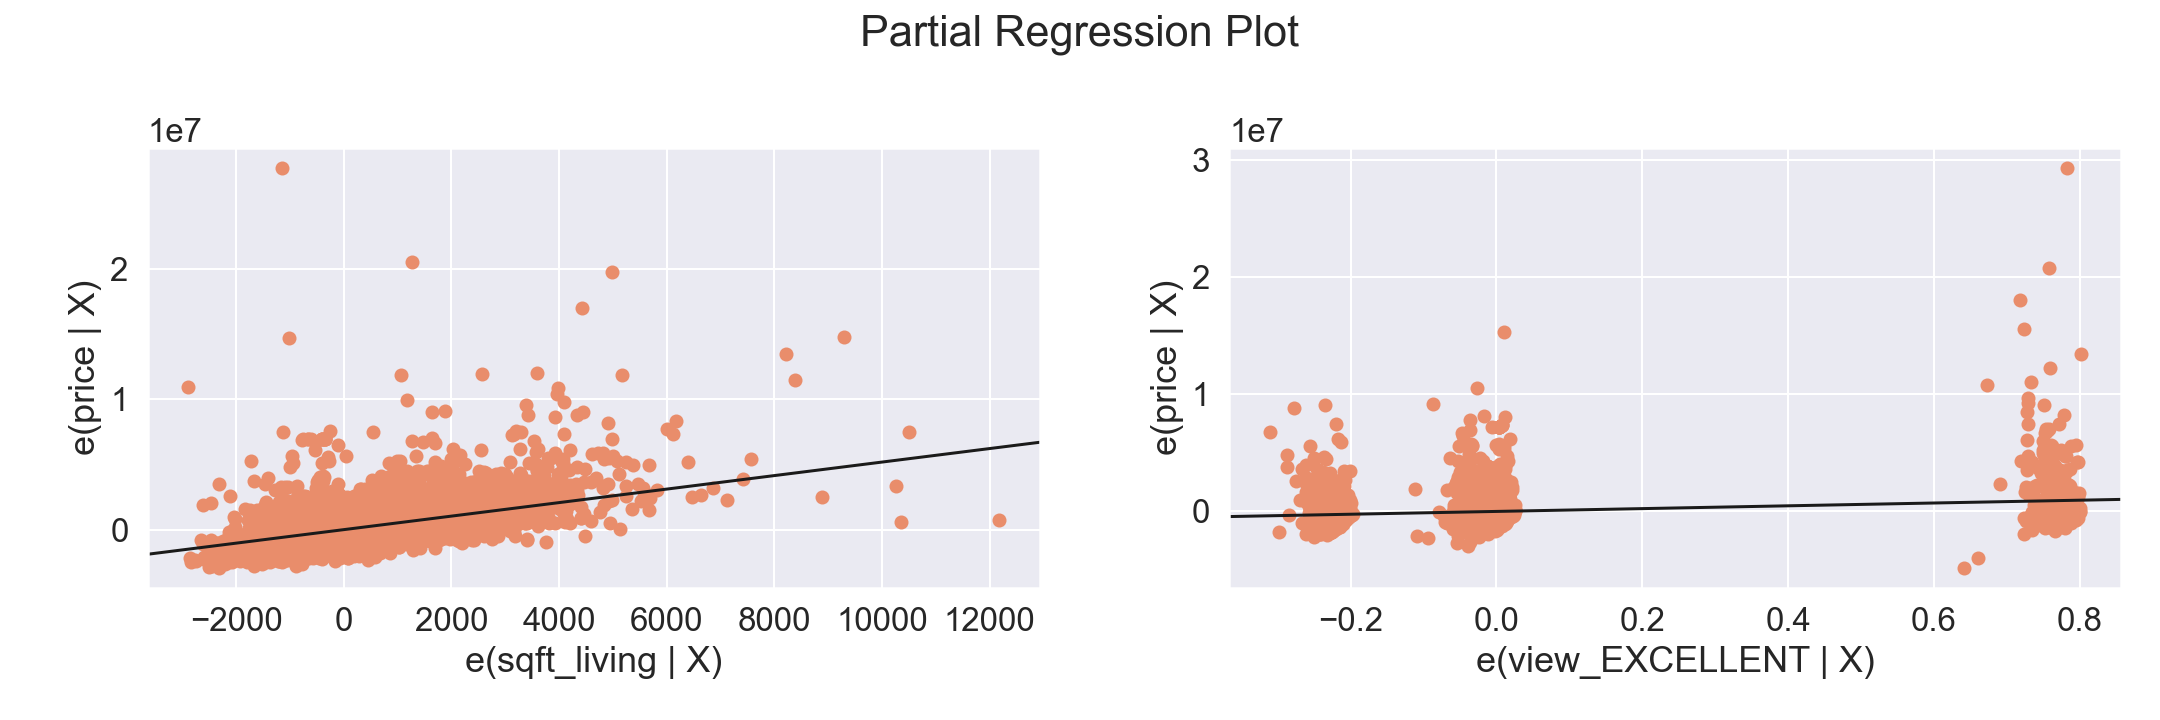

In [53]:
fig = plt.figure(figsize=(15,5))
sm.graphics.plot_partregress_grid(multi_results, exog_idx=["sqft_living", "view_EXCELLENT"], fig=fig)
plt.tight_layout()
plt.show()

This partial regression plot on the left shows the <em>marginal contribution</em> of the predictor, sqft_living. On the x-axis, it is showing the part of "sqft_living" that is not explained by the rest of the model, and on the y-axis, the part of 'price' that is not explained by the rest of the model.

This partial regression plot on the right shows the <em>marginal contribution</em> of the predictor, view_EXCELLENT. On the x-axis, it is showing the part of "view_EXCELLENT" that is not explained by the rest of the model, and on the y-axis, the part of 'price' that is not explained by the rest of the model.


##### Plotting the residuals:

<IPython.core.display.Javascript object>


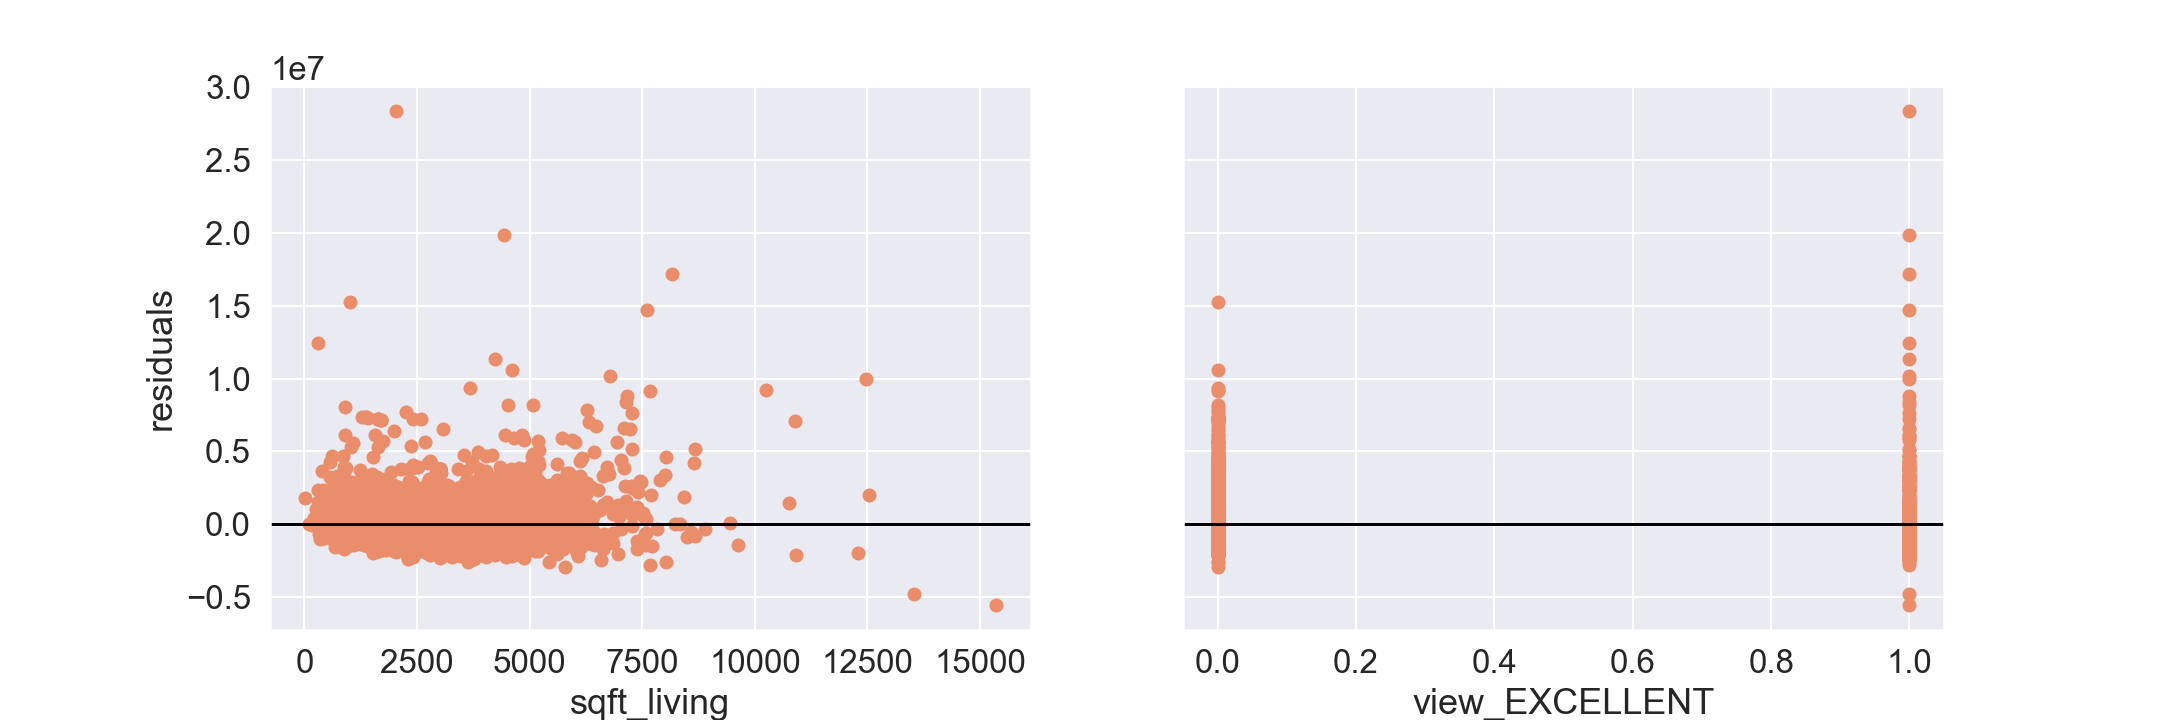

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)

sqftliving_ax = axes[0]
sqftliving_ax.scatter(multi_x["sqft_living"], multi_results.resid)
sqftliving_ax.axhline(y=0, color="black")
sqftliving_ax.set_xlabel("sqft_living")
sqftliving_ax.set_ylabel("residuals")

view_ax = axes[1]
view_ax.scatter(multi_x["view_EXCELLENT"], multi_results.resid)
view_ax.axhline(y=0, color="black")
view_ax.set_xlabel("view_EXCELLENT");

The model residuals are the <em>differences</em> between the actual and predicted values. From this plot, it looks like this model guessed values too high more often than it guessed them too low (similarly to the baseline model).

### MAE for interpretability of models:

##### MAE for baseline:

In [55]:
mae = baseline_results.resid.abs().sum() / len(y)
mae

396335.99168420106

Our baseline model is off by about $396,336 in a given prediction. This is pretty high for housing prices.

##### MAE for multiple linear regression model:

In [56]:
mae = multi_results.resid.abs().sum() / len(y)
mae

388646.59853549825

The first multiple linear regression model is off by about $388,646.60 in a given prediction. 

The model with the most improvement overall to the baseline model is the multiple linear regression model that included both sqft_living and view. This model had a higher R-squared (adjusted) value than the baseline and it had a lower MAE (mean absolute error) value.

## Conclusion

The models created show that the features that are most predictive of house sale price are the square feet of living space and the quality of the view. If the stakeholder is to only go off of this information, those are the two factors that they should look for when deciding which houses to buy in order to flip and make the highest possible profits.

### Limitations:
As can be seen in the QQ plot of the target variable 'price', the model becomes unreliable more than plus or minus 2 standard deviations away from the mean, or outside of the price range of 684,205.75 and 2,901,227.43 dollars.
The best model that was found still only explained 41.6% of the variance in price and was still estimated to be off by about 388,646.60 dollars on a given predicition, which is a pretty high number.
Additionally, this dataset does not include information on certain housing features that would likely be even more related to sale price, such as the subdivision that the house is in.

### Next Steps:
In order to get a better idea of the true best predictors of housing sale prices, further analysis should be conducted on more datasets that include more features, such as housing subdivision.


<img src="Images/kingcountyprices.png" alt="housing subdivisions" Style="height: 450px; width: 700px;">

This image shows how even within a county, housing prices can vary based on subdivision.